## Machine Learning Assignment 2

For this project, we need to develop a two machine learning models. One to predict if an image of a colon cell is cancerous or not and another model to predict the type of cell. These models will then be compared to other research projects that were conducted using the same dataset.

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import warnings
import zipfile
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

data = pd.read_csv('data_labels_mainData.csv')

### Exploratory Data Analysis

Lets see the data we are working with

In [2]:
data.shape

(9896, 6)

In [3]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [4]:
data['isCancerous'].unique()

array([0, 1])

In [5]:
data['cellType'].unique()

array([0, 1, 3, 2])

In [6]:
data['cellTypeName'].unique()

array(['fibroblast', 'inflammatory', 'others', 'epithelial'], dtype=object)

In [7]:
data[['cellType', 'cellTypeName']].drop_duplicates().sort_values('cellType')

,cellType,cellTypeName
0,0,fibroblast
11,1,inflammatory
449,2,epithelial
17,3,others


Observations:
- the 'isCancerous' target variable is binary encoded
- the 'cellType' target variable is categorical
- in the 'cellType' target variable: 
    - 0 corresponds to fibroblast
    - 1 corresponds to inflammatory
    - 2 corresponds to epithelial
    - 3 corresponds to others

Lets see if the classification of the 'isCancerous' target variable is balanced:

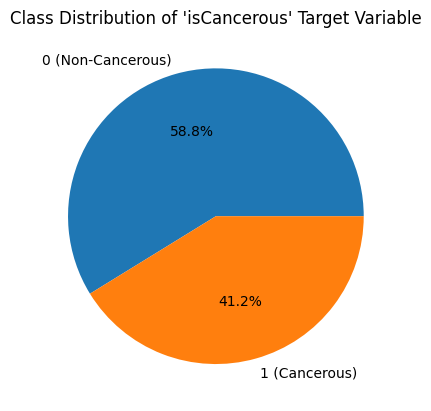

0 (Non-Cancerous): 5817
1 (Cancerous): 4079


In [8]:
import matplotlib.pyplot as plt

plt.title("Class Distribution of 'isCancerous' Target Variable")

class_count = data['isCancerous'].value_counts()

# number of samples in each class
class_counts = [class_count[0], class_count[1]]

# create the pie chart
plt.pie(class_counts, labels=['0 (Non-Cancerous)', '1 (Cancerous)'], autopct='%1.1f%%')
plt.show()
print("0 (Non-Cancerous):", class_count[0])
print("1 (Cancerous):", class_count[1])

Observations:
- the classes are slightly imbalanced
- the 0 (Non-Cancerous) class has approximately 1700 more samples which makes up 8.8% of the data

Lets see if the class distribution of the 'cellType' target variable is balanced:

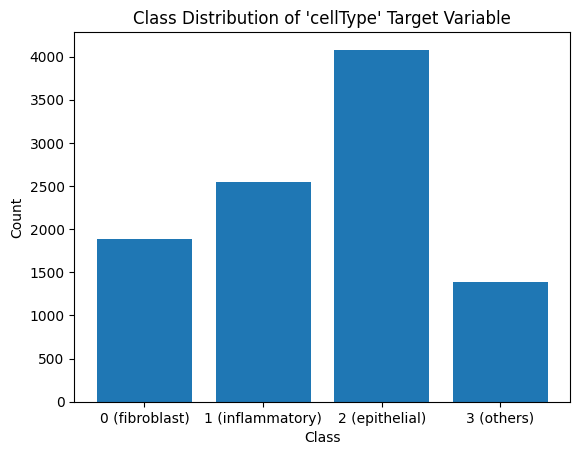

In [9]:
# create the mapping from cellType to cellTypeName
mapping = data[['cellType', 'cellTypeName']].drop_duplicates().sort_values('cellType')
labels = [f"{row['cellType']} ({row['cellTypeName']})" for _, row in mapping.iterrows()]

# get counts for each cellType (ordered by cellType to match labels)
class_counts = data['cellType'].value_counts().sort_index()

# Create bar plot
plt.bar(labels, class_counts)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title("Class Distribution of 'cellType' Target Variable")
plt.show()


Observations:
- high imbalance in the class distribution of the 'cellType' target variable
- will need class weights to balance them while fitting the model later on

Lets see if we have any null values in the data:

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


Observations:
- there are no null values in the data
- the datatype of the 'cellType' column is int but it is better to it as categorical

Lets examine the statistical analysis of the data:

In [11]:
data.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


Lets look at a few randomly selected images in each class of the 'isCancerous' target variable to see the variation in the images:

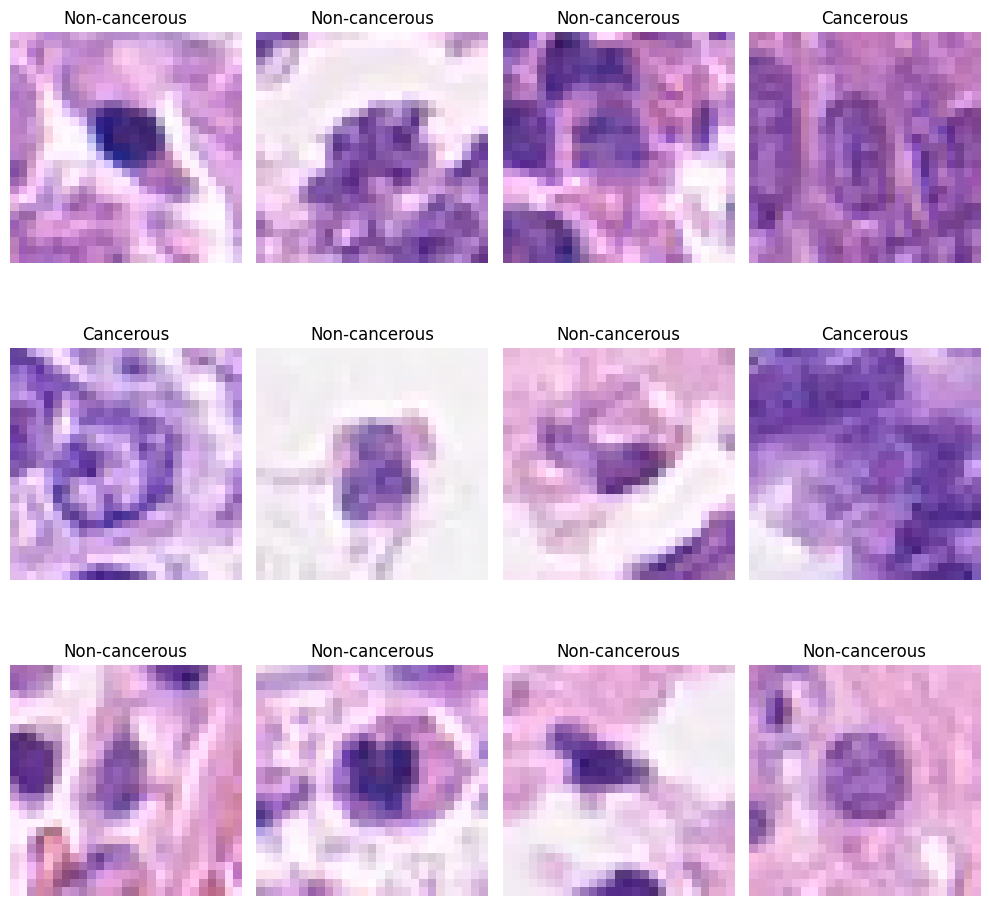

In [12]:
from PIL import Image

# defining class labels
class_labels = ['Non-cancerous', 'Cancerous']

# randomly selecting images
num_samples = 12
sample_df = data.sample(num_samples)

# plotting the images in a grid
fig, axes = plt.subplots(3, 4,  figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image_path = sample_df.iloc[i]['ImageName']
    label = sample_df.iloc[i]['isCancerous']

    # loading and displaying the images
    image = Image.open('./patch_images/' + image_path)
    ax.axis('off')
    ax.set_title(class_labels[label])
    ax.imshow(image)

plt.tight_layout()
plt.show()

Lets look at a few randomly selected images in each class of the 'cellType' target variable to see the variation in the images:

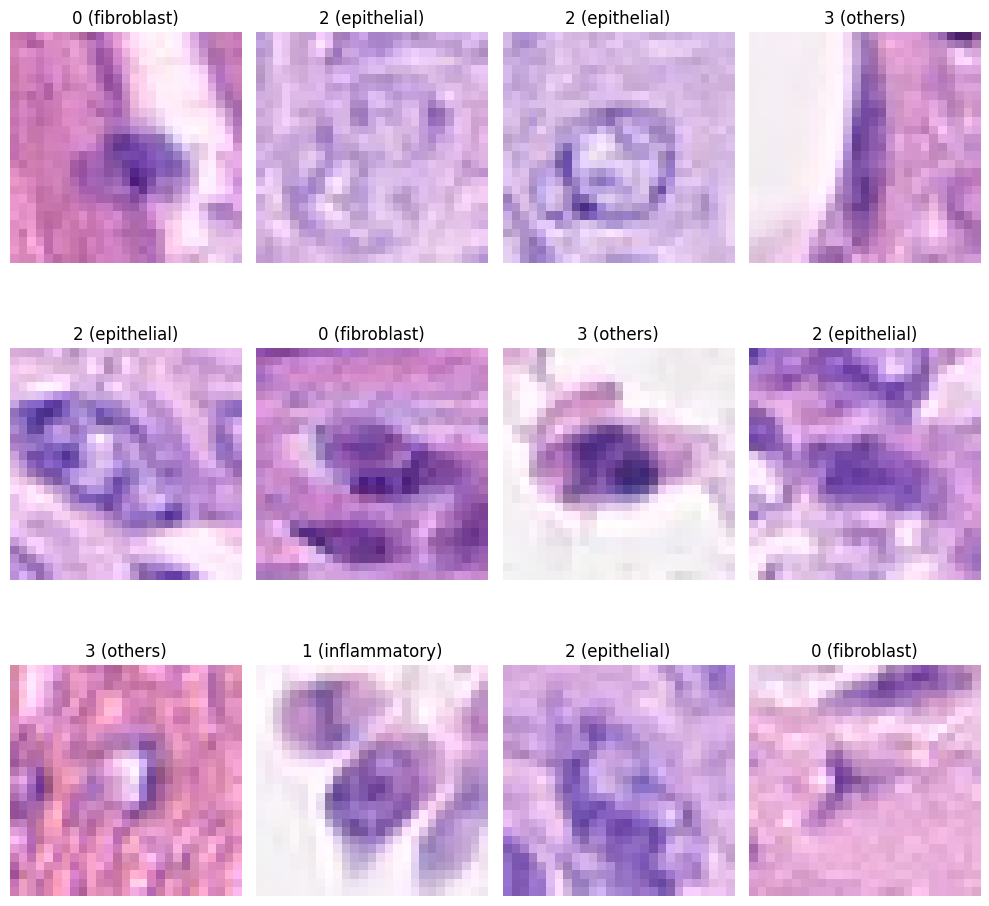

In [13]:
# Selecting a subset of images to see
num_samples = 12
sample_df = data.sample(num_samples)

# Plotting the sample images in a grid
fig, axes = plt.subplots(3, 4,  figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image_path = sample_df.iloc[i]['ImageName']
    label_num = sample_df.iloc[i]['cellType']
    label_name = sample_df.iloc[i]['cellTypeName']

    # Load and display the image
    image = Image.open('./patch_images/' + image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{label_num} ({label_name})")

plt.tight_layout()
plt.show()

Observations:
- the cells are of different sizes and shapes
- the cells also seem to be in different orientations
- some images are brighter than others

### Data Pre Processing

Lets start by changing the datatype of the cellType column to categorical:

In [14]:
data['cellType'] = data['cellType'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   InstanceID    9896 non-null   int64   
 1   patientID     9896 non-null   int64   
 2   ImageName     9896 non-null   object  
 3   cellTypeName  9896 non-null   object  
 4   cellType      9896 non-null   category
 5   isCancerous   9896 non-null   int64   
dtypes: category(1), int64(3), object(2)
memory usage: 396.6+ KB


Lets fix the imbalanced class distribution of the 'cellType' target variable that we observed in the EDA.

In [15]:
from sklearn.utils import class_weight

# Calculating class weights
ct_class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(data['cellType'].values), y = data['cellType'].values)

# converting class weights to a dictionary for use when fitting the model
ct_class_weights_dict = dict(enumerate(ct_class_weights))

Lets address the differences in cell sizes, orientations, and the brightness of the images.\
For the cell sizes we will randomly zoom in on all the images in a range between 0 to 0.08 (8%)\
For the cell orientations we will randomly rotate the images in a range of -15 to 15\
For the brightness we will randomly apply a brightness between 80% - 120%\
This should help standardize all the images of the cells and create some sort of consistency between them all

In [16]:
# We have to convert 'isCancerous' to string type for the flow_from_dataframe function to work properly
data['isCancerous'] = data['isCancerous'].astype('string')

datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

augmented_data = datagen.flow_from_dataframe(
    dataframe=data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27), # image size
    class_mode='binary', # binary classification for cancerous and non-cancerous
    batch_size=batch_size, # batch size (amount of data to be processed at once)
    brightness_range =[0.8, 1.2], # applying random brightness range for augmentation
    rotation_range =15, # applying random rotation for augmentation
    zoom_range = 0.08, # applying random zoom for augmentation
    fill_mode='nearest', # filling in missing pixels after rotation/zoom
    shuffle=True, # shuffling the data for randomness in batch order 
)

Found 9896 validated image filenames belonging to 2 classes.


Lets split the data and get it ready for training the model

In [17]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.25, shuffle=True)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], val_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1979


Lets check if the class distibution of the 'isCancerous' variable in the training, validation, and test data sets is similar to the class distribution of the overall data

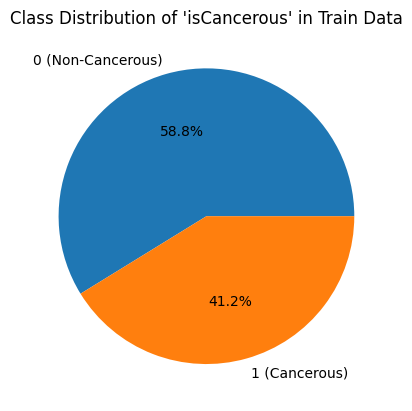

0 (Non-Cancerous): 3518
1 (Cancerous): 2419


In [18]:
train_data['isCancerous'] = train_data['isCancerous'].astype(int)
plt.title("Class Distribution of 'isCancerous' in Train Data")

train_data_class_count = train_data['isCancerous'].value_counts()

# number of samples in each class
train_data_class_counts = [class_count[0], class_count[1]]

# create the pie chart
plt.pie(train_data_class_counts, labels=['0 (Non-Cancerous)', '1 (Cancerous)'], autopct='%1.1f%%')
plt.show()
print("0 (Non-Cancerous):", train_data_class_count[0])
print("1 (Cancerous):", train_data_class_count[1])

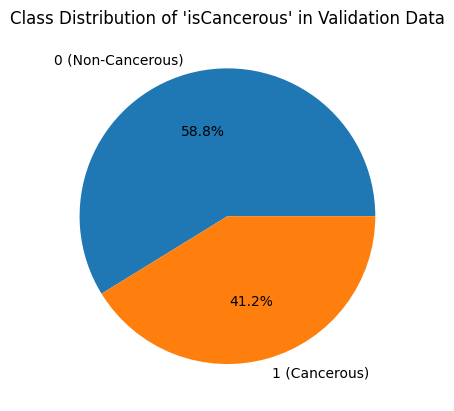

0 (Non-Cancerous): 5817
1 (Cancerous): 4079


In [19]:
val_data['isCancerous'] = val_data['isCancerous'].astype(int)
plt.title("Class Distribution of 'isCancerous' in Validation Data")
val_data_class_counts = [class_count[0], class_count[1]]

# create the pie chart
plt.pie(val_data_class_counts, labels=['0 (Non-Cancerous)', '1 (Cancerous)'], autopct='%1.1f%%')
plt.show()
print("0 (Non-Cancerous):", val_data_class_counts[0])
print("1 (Cancerous):", val_data_class_counts[1])

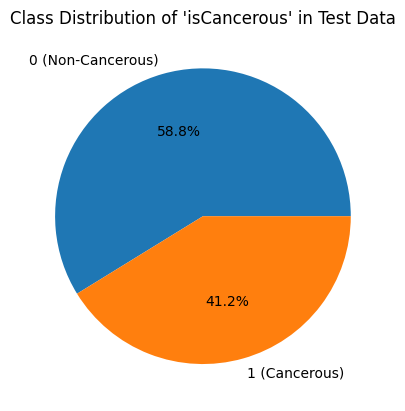

0 (Non-Cancerous): 1144
1 (Cancerous): 836


In [20]:
test_data['isCancerous'] = test_data['isCancerous'].astype(int)
plt.title("Class Distribution of 'isCancerous' in Test Data")

test_data_class_count = test_data['isCancerous'].value_counts()

# number of samples in each class
test_data_class_counts = [class_count[0], class_count[1]]

# create the pie chart
plt.pie(test_data_class_counts, labels=['0 (Non-Cancerous)', '1 (Cancerous)'], autopct='%1.1f%%')
plt.show()
print("0 (Non-Cancerous):", test_data_class_count[0])
print("1 (Cancerous):", test_data_class_count[1])

Lets check if the class distibution of the 'cellType' variable in the training, validation, and test data sets is similar to the class distribution of the overall data

In [21]:
def classDistribution(dataset, code_col, name_col, datasetName):
    # create mapping of code to name
    mapping = dataset[[code_col, name_col]].drop_duplicates().sort_values(code_col)
    labels = [f"{row[code_col]} ({row[name_col]})" for _, row in mapping.iterrows()]
    
    # get class counts sorted by code_col to align with labels
    class_counts = dataset[code_col].value_counts().sort_index()

    plt.bar(labels, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f"Class Distribution of '{code_col}' in {datasetName}")
    plt.show()

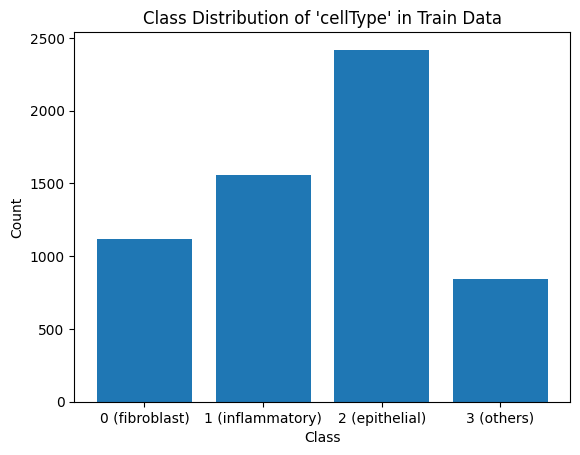

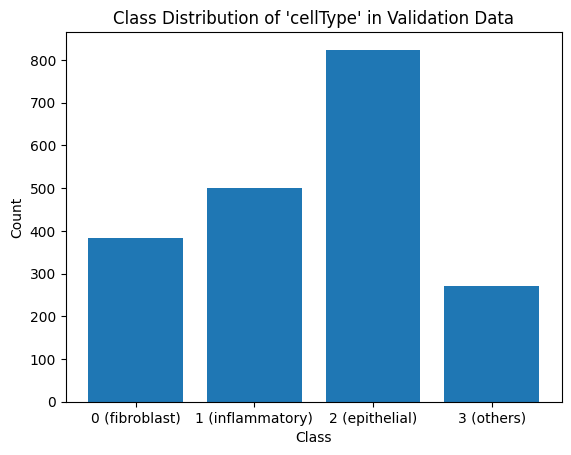

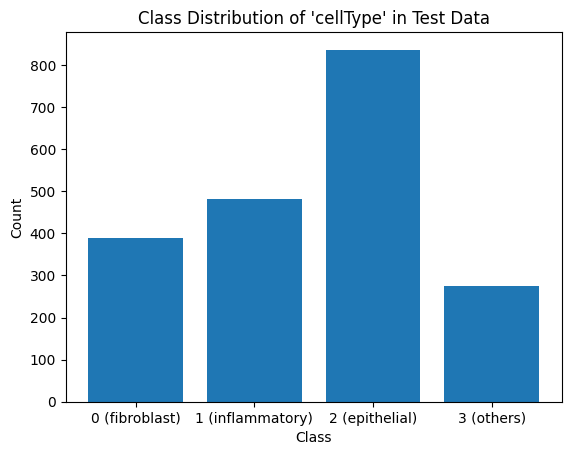

In [22]:
classDistribution(train_data, 'cellType', 'cellTypeName', 'Train Data')
classDistribution(val_data, 'cellType', 'cellTypeName', 'Validation Data')
classDistribution(test_data, 'cellType', 'cellTypeName', 'Test Data')

Observations:
- the distribution of the samples in the training, validation, and test data sets are all identical to the distribution of the data before the split

In the exploratory data analysis we observed a slight imbalance in the classes of the target variable 'isCancerous'. This could cause the model to be overfitted but since it is just a slight imbalance and the distribution of the classes of the target variable in our training, validation, and testing datasets are identical to the distribution of the classes in the target variable in the data before the split, we will not perform any adjustments to it as of right now. We will leave it and investigate once we build the model if this slight imbalance has an effect.

### Baseline Model to predict 'isCancerous'

For this project, a custom fit traditional neural network (NN) was chosen for its abilities to easily classify images without using vast amounts of processing power. It was chosen over a convolutional neural network (CNN) for this very reason.

Misclassifying a cell as cancerous or non-cancerous will be a very costly mistake in terms of the patients health and allocation of medical resources so when choosing a metric we need to choose one like recall which makes sure to minimize false negatives. If we optimize for recall, this might result in an increase in false positives which means that we are now dealing with the same problem. So to minimize false positives and ensure a balance we will also use precision as the other performance metric.

The two performance metrics we will focus on are:
- recall
- precision

To build this model we will use the sequential library, as that is the easiest to work with. We will also set the layer dimension hyperparameter to 256, we can change this later as we can see fit. We will set the model's output classes to 1 so that it matches the output of our 'isCancerous' variable. 

In [23]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

AUTOTUNE = tf.data.experimental.AUTOTUNE

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

Lets see the structure of the model

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,385 (2.14 MB)

 Trainable params: 560,385 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

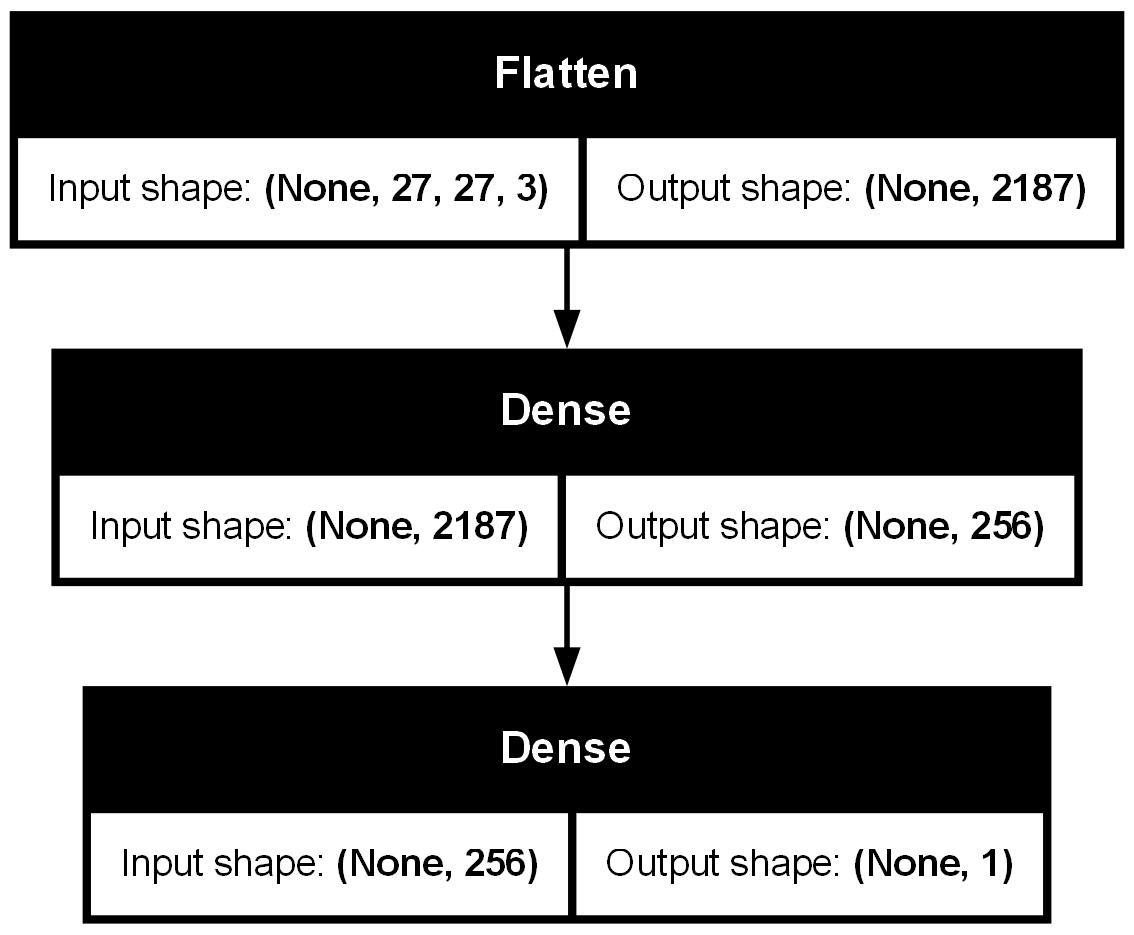

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

This shows the different steps (or layers) that our model will use and the outputs of each layer until we receive its prediction for an image (represented in the output shape of 1 in the final step as we will only get 1 result per image).

Lets compile the model.\
We will use binary cross entropy for the loss function since our target variable 'isCancerous' is binary.

In [26]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['Precision', 'Recall'],
)

Lets train the baseline model.\
We first need to convert the target variable datatype to string first so that we can use the flow_from_dataframe function.

In [27]:
train_data['isCancerous'] = train_data['isCancerous'].astype('string')
val_data['isCancerous'] = val_data['isCancerous'].astype('string')

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


Lets see the learning curve on the training and validation sets and see the loss values to compare the performance metrics.

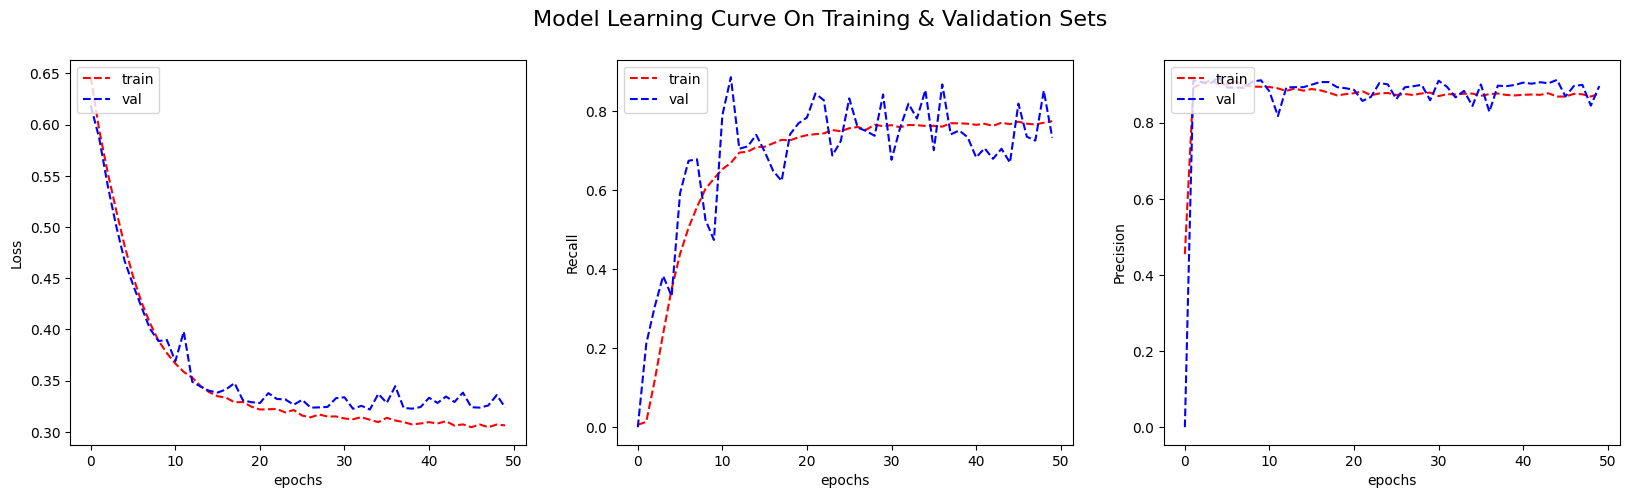

In [28]:
def plot_learning_curve(train_loss, val_loss, train_metric_1, val_metric_1, train_metric_2, val_metric_2, metric_name_1, metric_name_2, title):
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,3,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,3,2)
    plt.plot(train_metric_1, 'r--')
    plt.plot(val_metric_1, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name_1)
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,3,3)
    plt.plot(train_metric_2, 'r--')
    plt.plot(val_metric_2, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name_2)
    plt.legend(['train', 'val'], loc='upper left')
    plt.suptitle(title, fontsize=16)
    plt.show()
    
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                history.history['Recall'], history.history['val_Recall'],  
                history.history['Precision'], history.history['val_Precision'],
                metric_name_1='Recall', 
                metric_name_2='Precision',
                title='Model Learning Curve On Training & Validation Sets')

Observations:
- validation set contains a considerable amount of noise
- loss decreases as the model learns
- recall and precision increase and eventually plateau as the model learns
- the validation set keeps increasing and decreasing but is still similar to the training set overall
- higher passthrough amounts of the validation dataset causes the recall of the model to get worse while the precision gets better

Lets see the model's performance on the test dataset:

In [29]:
test_data['isCancerous'] = test_data['isCancerous'].astype('string')
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
model.evaluate(test_generator)

Found 1980 validated image filenames belonging to 2 classes.
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - Precision: 0.9162 - Recall: 0.7334 - loss: 0.2861


[0.28553521633148193, 0.9123563170433044, 0.7595694065093994]

Observations:
- The model correctly predicts if a cell is cancerous or not 92.12% (precision) of the time
- The model correctly identifies 65.98% (recall) of all cancerous images
- There is a loss of 30.42% meaning there is a difference of about 30% between the predicted and the actual results.

Lets look at a sample of 10 images of cells and see how our baseline model predicts if some random samples are cancerous or not:

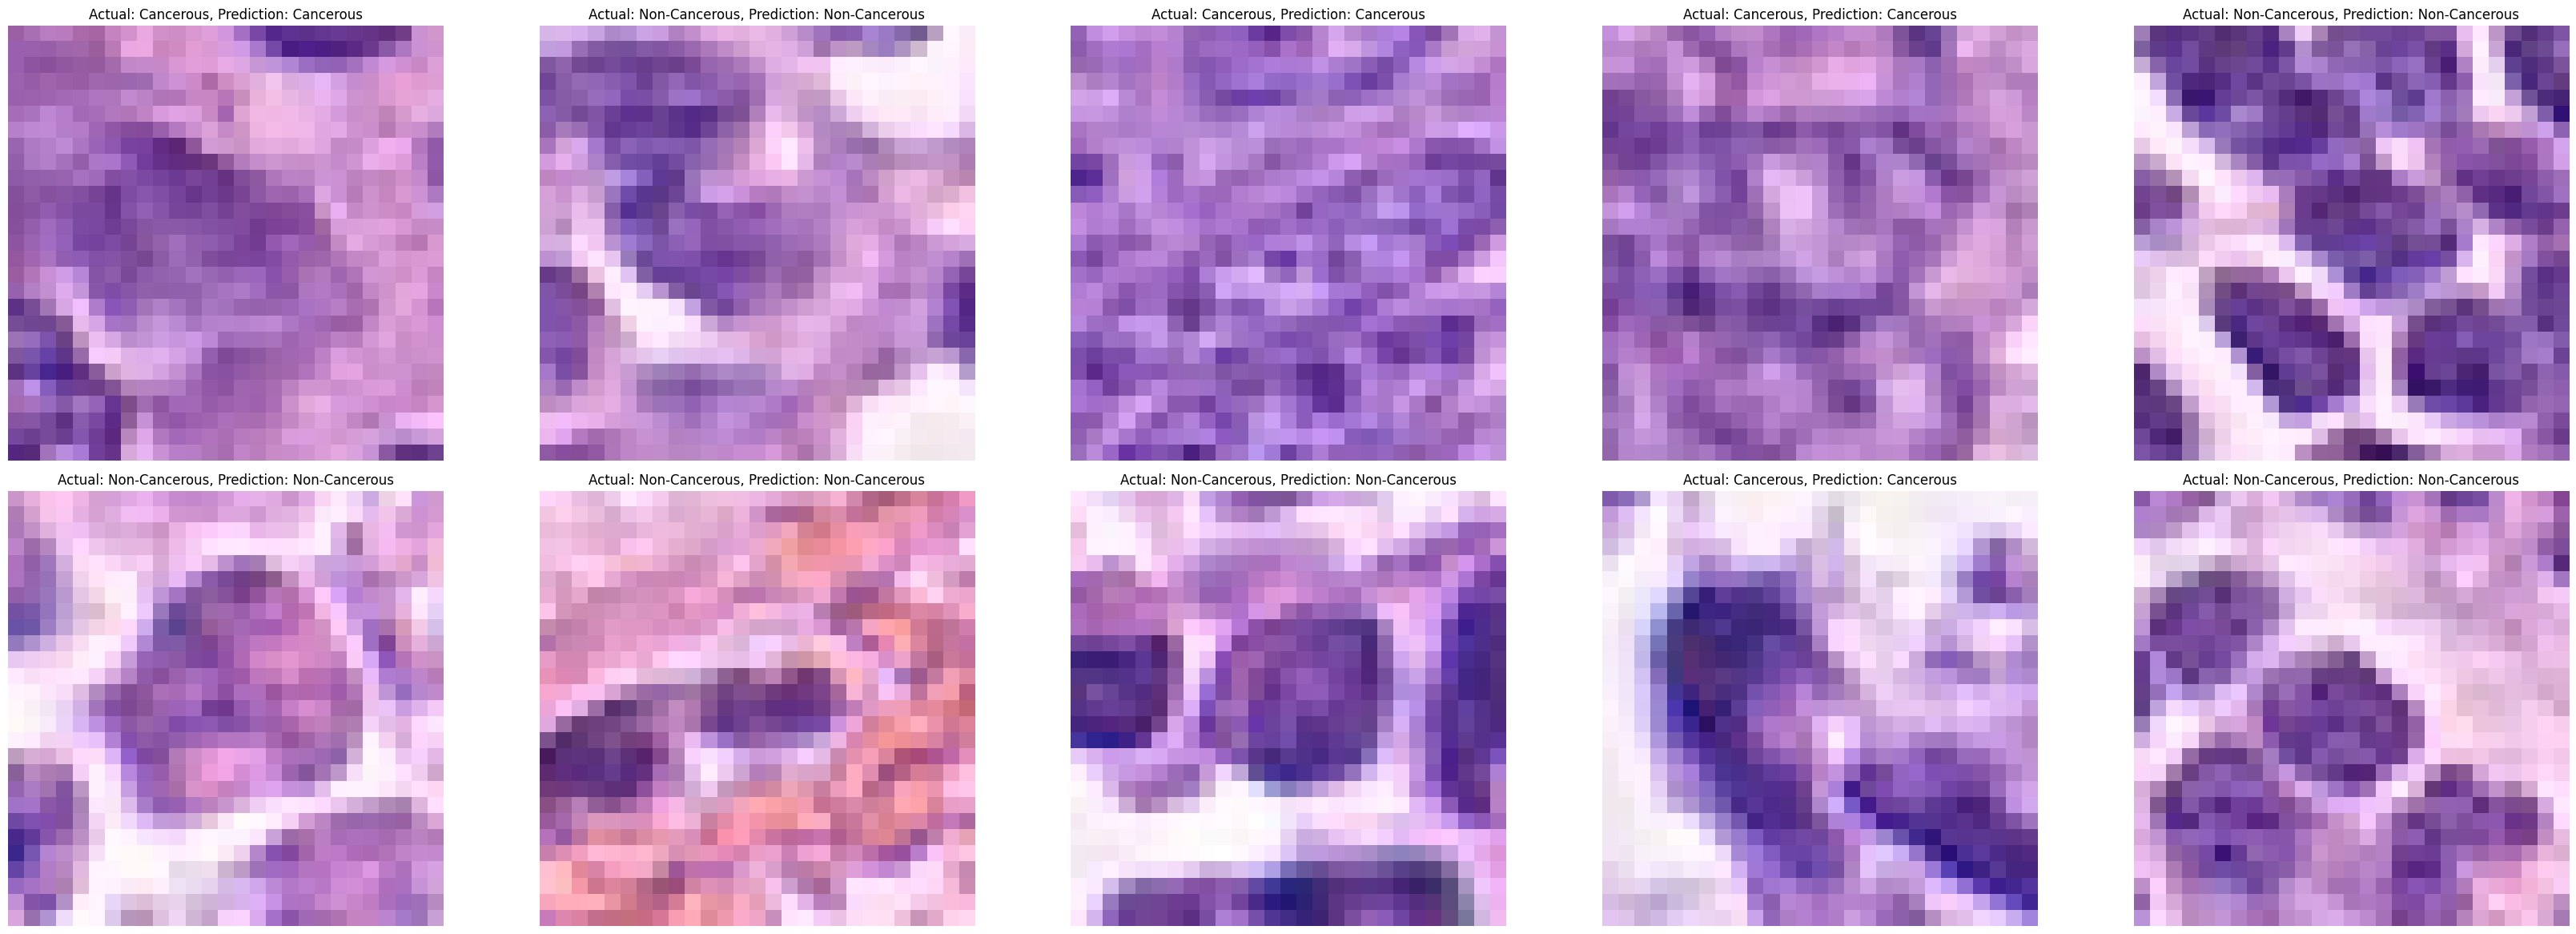

In [30]:
label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(35,12))
batches = 0
num_images_to_display = 10
rows = 2
cols = (num_images_to_display + rows - 1) // rows

for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches <= num_images_to_display:
            row_index = (batches - 1) // cols
            col_index = (batches - 1) % cols + 1
            plt.subplot(rows,cols,batches)
            plt.imshow(x[0])

            actual_class = d_inv[int(y[0])]  # Directly use the binary label
            predicted_probability = y_hat[0][0] # Get the probability of the cell being cancerous
            predicted_class = d_inv[1] if predicted_probability >= 0.5 else d_inv[0]

            plt.title(f"Actual: {actual_class}, Prediction: {predicted_class}")
            
        else:
            break
        plt.tight_layout()
        plt.axis('off')

### Hyper Parameter Tuning
#### Regularization
To improve the model, we will apply regularization. We will use ridge regularization (L2) since it usually leads to a more smooth/stable model which might help the instability in our validation model. Applying L2 regularization will also lead to a smoother model because L1 regularization tends to push alot of wieghts to 0, which removes certain features (feature selection).

We will also test the L2 regularization with the following lambda values and see which leads to the best result:
- 0.0
- 0.002
- 0.02

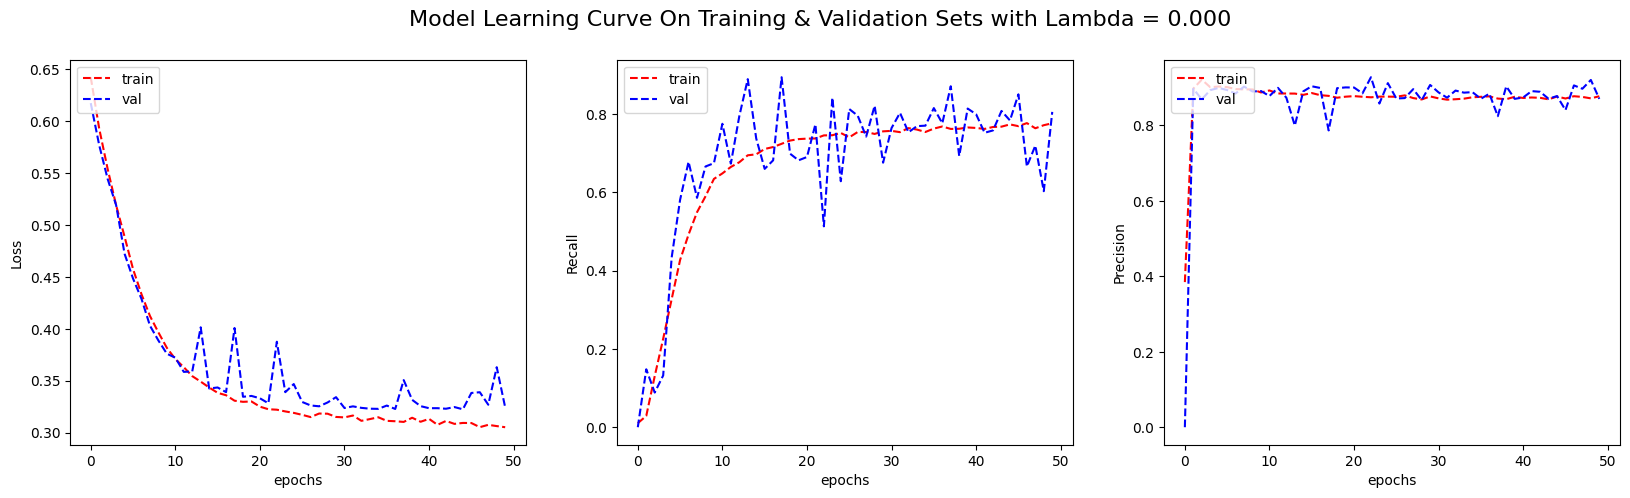

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2740 - precision_1: 0.8883 - recall_1: 0.8302


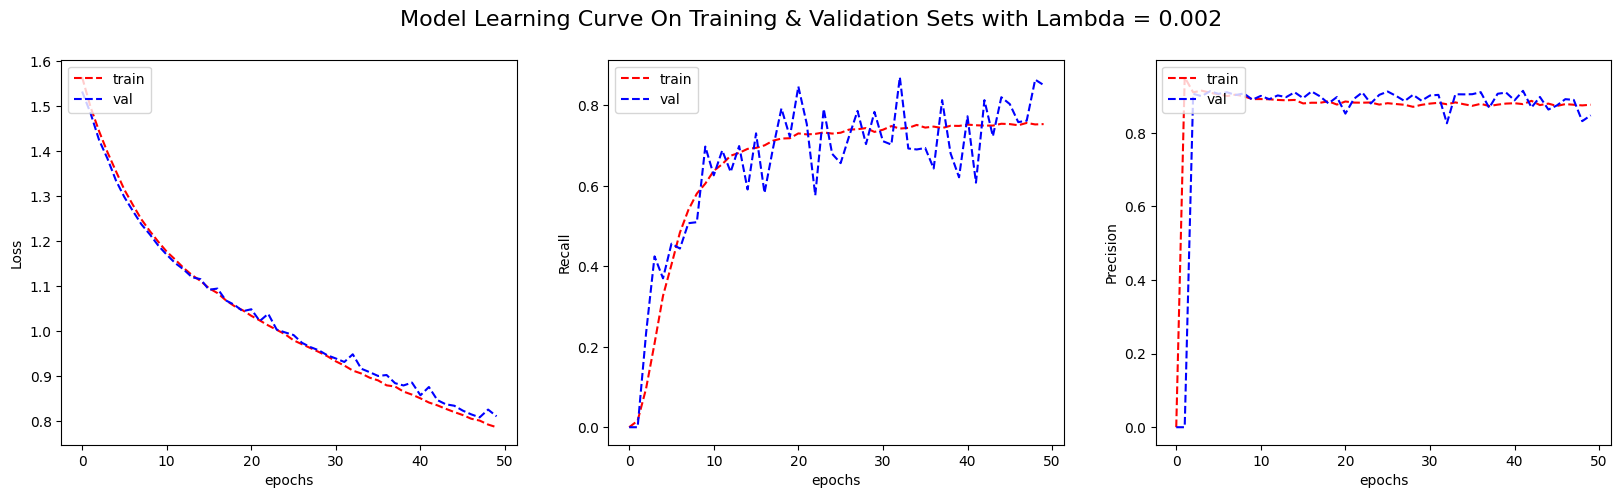

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7688 - precision_2: 0.8806 - recall_2: 0.8623


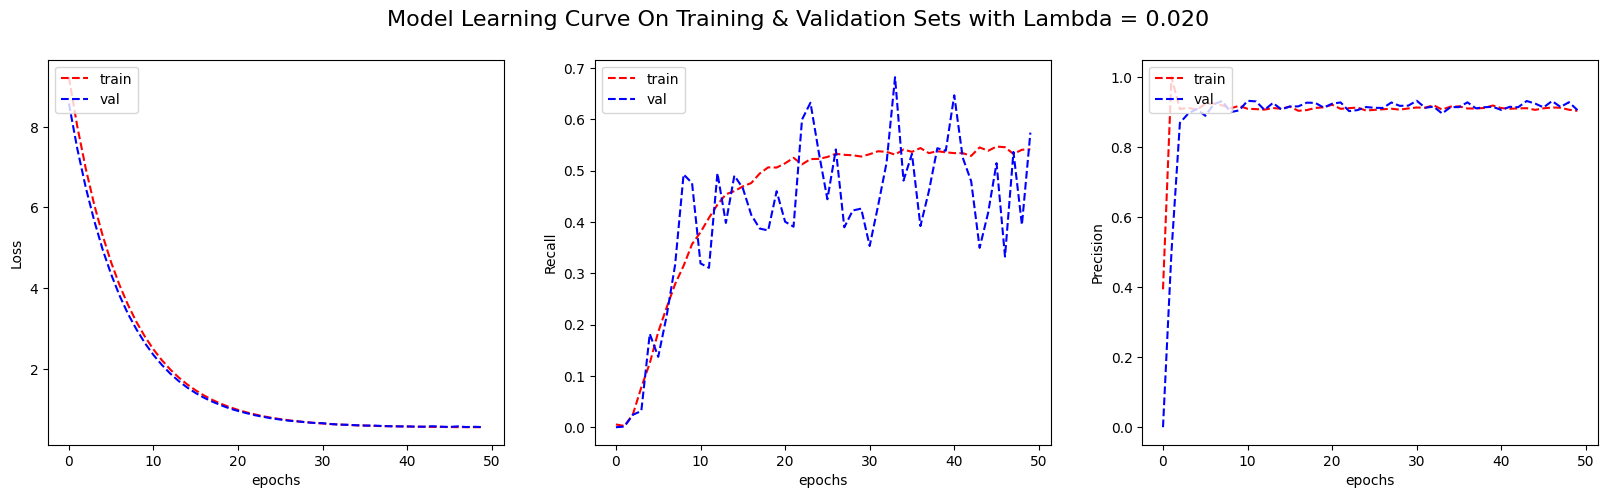

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5389 - precision_3: 0.9323 - recall_3: 0.6306


In [31]:
l2_vals = [0.0, 0.002, 0.02]

for i,ridge in enumerate(l2_vals):
    new_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(ridge)),
    tf.keras.layers.Dense(OUTPUT_CLASSES,kernel_regularizer=tf.keras.regularizers.l2(ridge))
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01,momentum = 0.0)
    new_model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    new_history = new_model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
    var = list(new_history.history.keys())
    title = f'Model Learning Curve On Training & Validation Sets with Lambda = {ridge:.3f}'
    plot_learning_curve(new_history.history['loss'], new_history.history['val_loss'], 
                    new_history.history[var[2]], new_history.history[var[5]],
                    new_history.history[var[1]], new_history.history[var[4]], 
                    "Recall", "Precision", title)
    new_model.evaluate(test_generator)

Observations:
- lambda 0.002 and 0.02 increase the loss function for both training and validation sets
- lambda 0.02 has a slight improvement in precision in both training and validation sets but recall suffers
- alot of noise remains in the recall metric on the validation set
- all lambda values result in a worse overall performance of the model indicating overfitting

#### Hidden Layer Sizes

Since ridge regularization leads to a decrease in overall performance we will not use it. However we still have to improve the model so we will try reducing the model complexity by trying different hidden layer sizes.

We will try the following hidden layer sizes:
- 50
- 150
- 200

In [45]:
HIDDEN_VALS = [50, 100, 150]

for ridge in HIDDEN_VALS:
    HIDDEN_LAYER_DIM = ridge
    new_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01,momentum = 0.0)
    new_model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    new_history = new_model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
    var = list(new_history.history.keys())
    title = f'Model Learning Curve On Training & Validation Sets with Hidden Layer Size = {ridge:.3f}'
    plot_learning_curve(new_history.history['loss'], new_history.history['val_loss'], 
                    new_history.history[var[2]], new_history.history[var[5]],
                    new_history.history[var[1]], new_history.history[var[4]], 
                    "Recall", "Precision", title)
    new_model.evaluate(test_generator)

TypeError: plot_learning_curve() missing 3 required positional arguments: 'metric_name_2', 'metric_name_3', and 'title'

Observations:
- the noise in the validation set decreased in all hidden layer sizes (50, 100, and 150) but we still have some noise remaining
- loss increased to 32.37% with 150 as the hidden layer size
- recall decreased to 79.53% with 50 as the hidden layer size
- loss decreased and both recall and precision metrics increased with 100 as the hidden layer size so we will use that


#### Dropout Validation
The fact that we still have noise in the validation set indicates that our model is predicting wrong alot of the time when given unseen data. To reduce this we will try applying dropout tuning since it might help because it drops the weights of the features that might be causing the outliers.

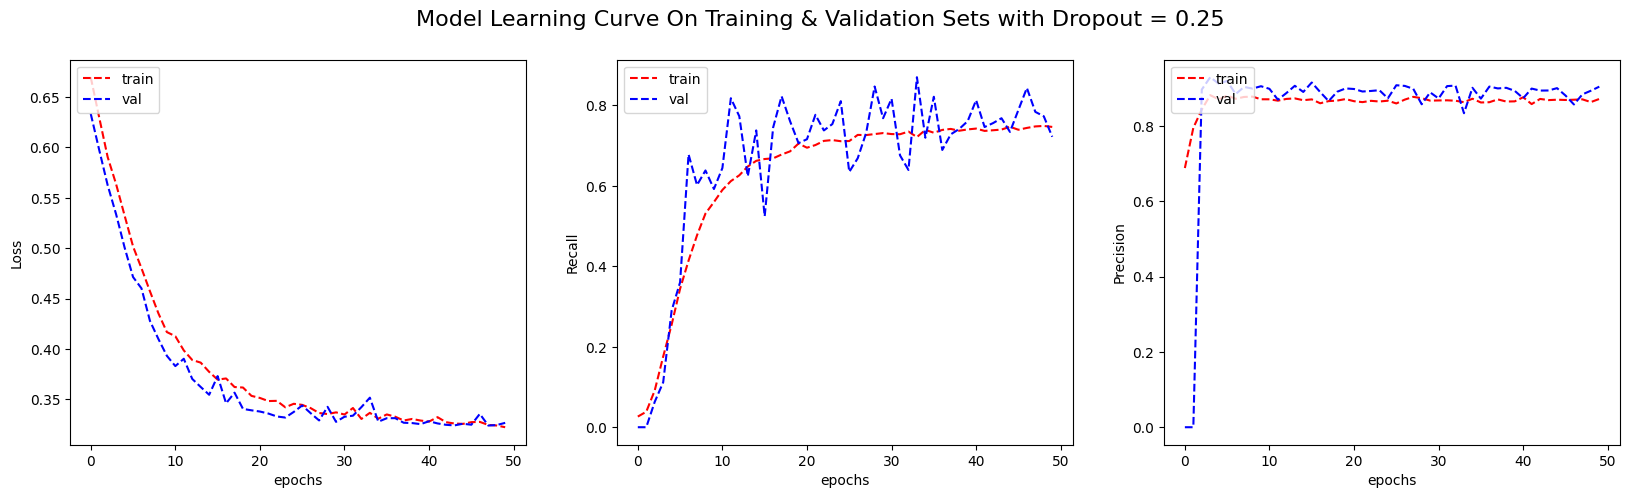

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3090 - precision_7: 0.9197 - recall_7: 0.7338


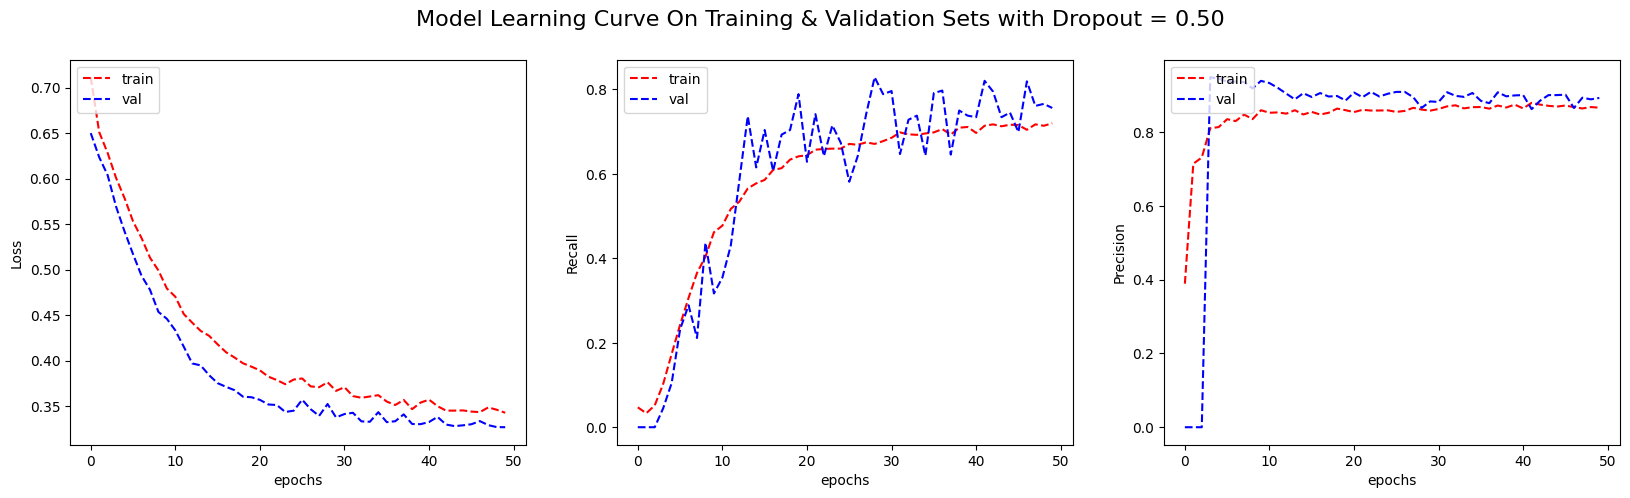

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3015 - precision_8: 0.9159 - recall_8: 0.7657


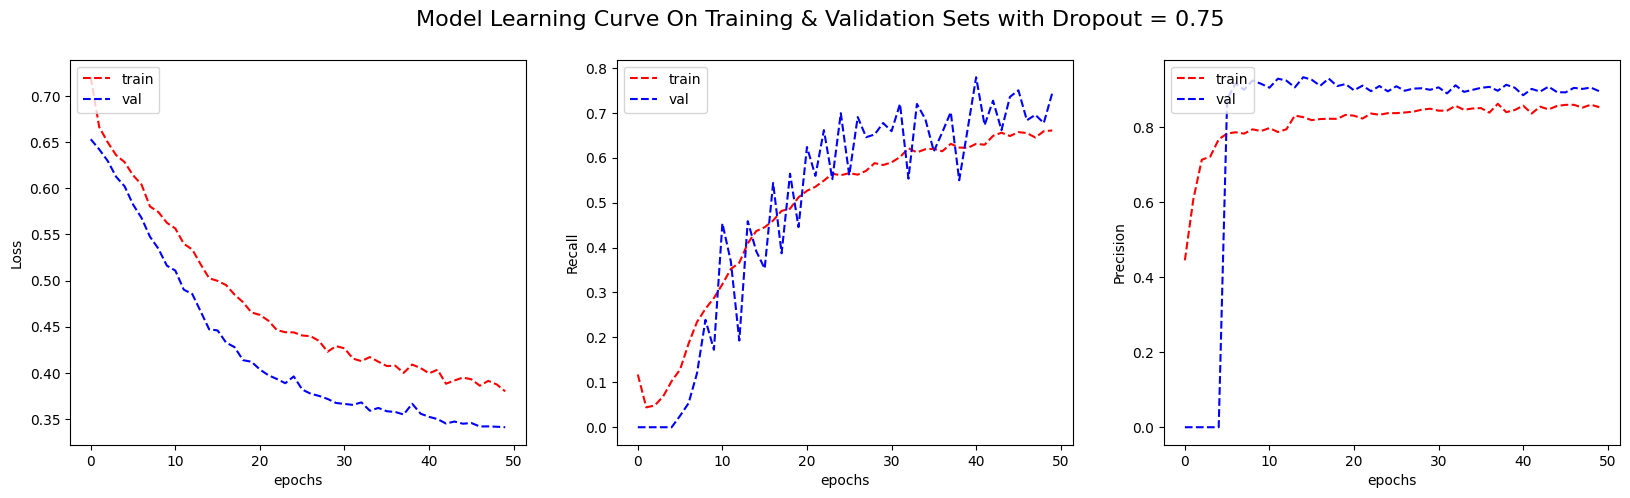

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3311 - precision_9: 0.8903 - recall_9: 0.7534


In [33]:
dropout_vals = [0.25,0.5,0.75]
HIDDEN_LAYER_DIM = 100
for i,dp in enumerate(dropout_vals):
    new_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(dp),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01,momentum = 0.0)
    new_model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    new_history = new_model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
    var = list(new_history.history.keys())
    plot_learning_curve(new_history.history['loss'], new_history.history['val_loss'], 
                    new_history.history[var[2]], new_history.history[var[5]],
                    new_history.history[var[1]], new_history.history[var[4]],
                    "Recall", "Precision",
                    title = f'Model Learning Curve On Training & Validation Sets with Dropout = {dp:.2f}') 
    new_model.evaluate(test_generator)

Observations:
- noticeable improvement in noise in the validation set
- large gap between training and validation sets with dropout 0.5 
- gap between training and validation sets gets even larger with dropout 0.75 
- dropout 0.25 has the best reduction in noise for the validation set while also maintaining balance with training and validation sets

#### Reducing epochs
Lets see if we can improve the model more by reducing the epochs.

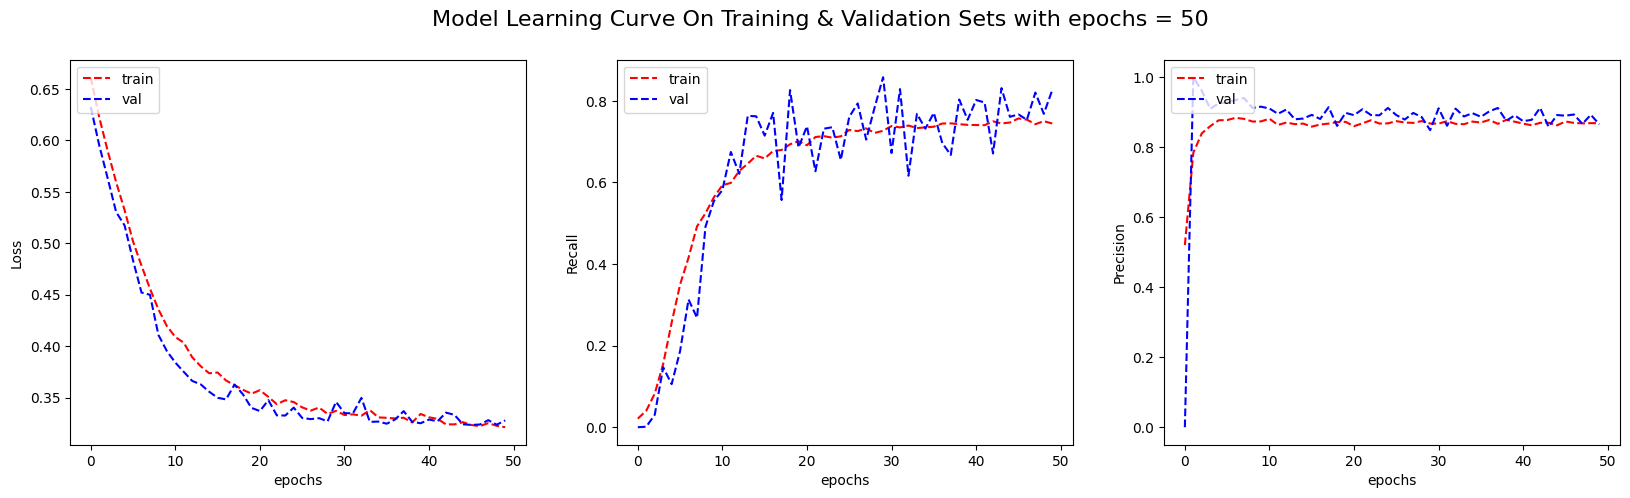

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2806 - precision_10: 0.8970 - recall_10: 0.8439


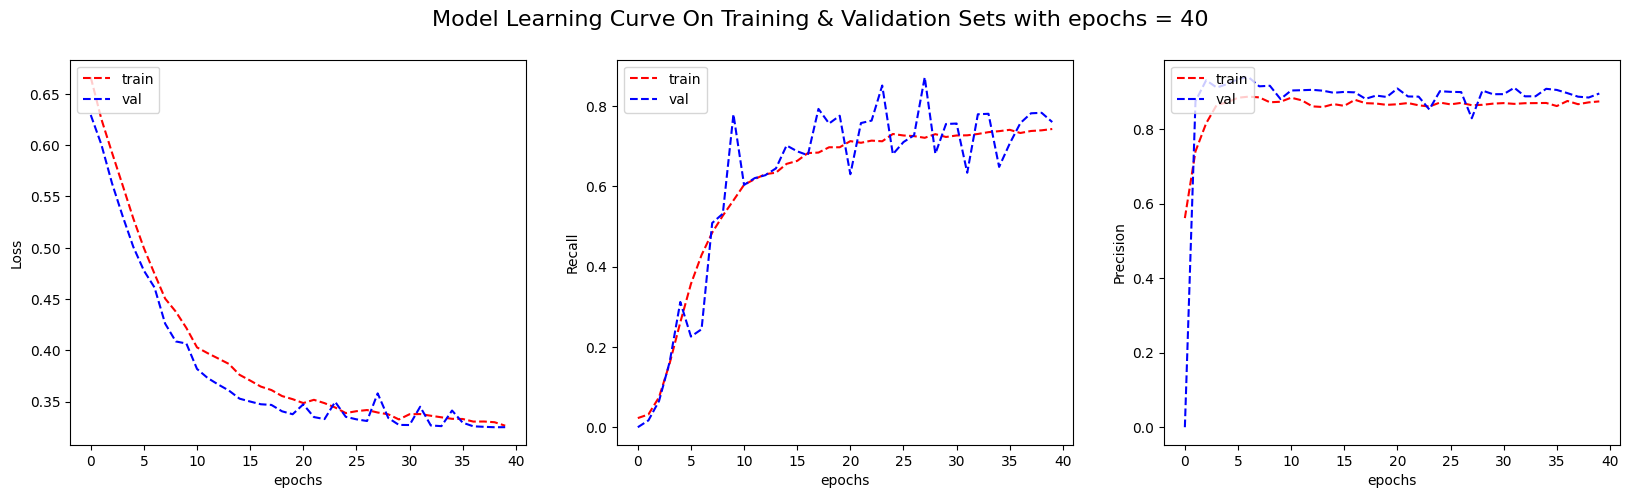

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3107 - precision_11: 0.9045 - recall_11: 0.7641


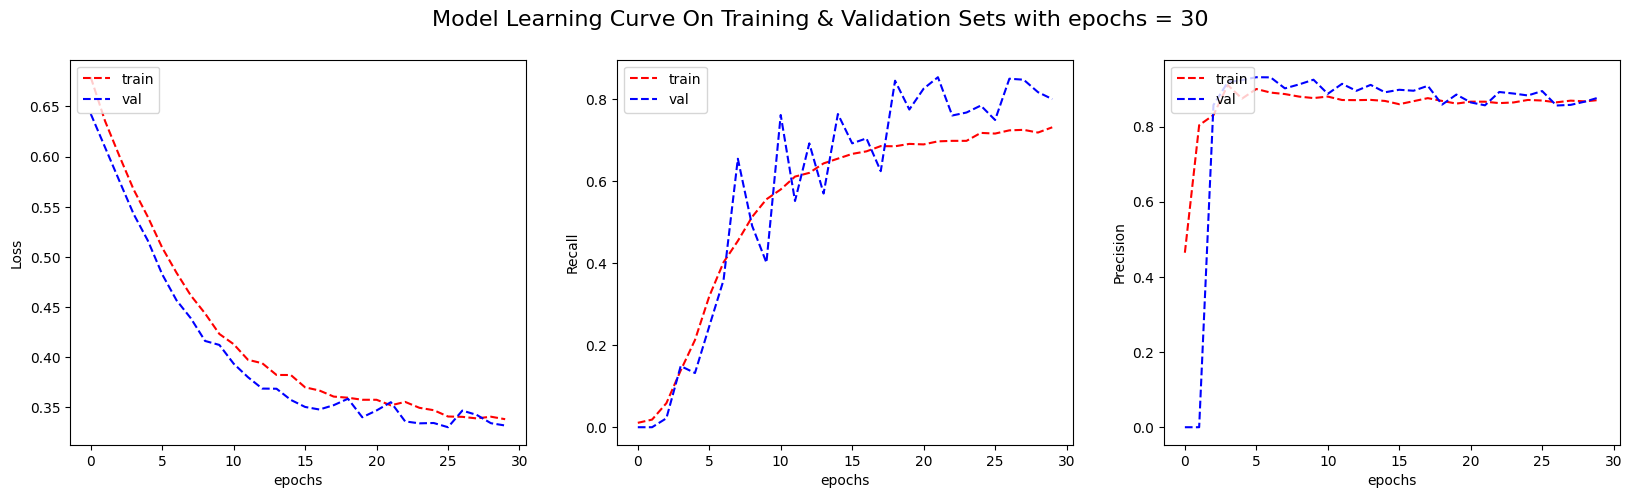

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2916 - precision_12: 0.8858 - recall_12: 0.8310


In [34]:
epochs_vals = [50,40,30]
HIDDEN_LAYER_DIM = 100
for i,epochs_val in enumerate(epochs_vals):
    new_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01,momentum = 0.0)
    new_model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    new_history = new_model.fit(train_generator, validation_data = validation_generator, epochs=epochs_val, verbose=0)
    var = list(new_history.history.keys())
    plot_learning_curve(new_history.history['loss'], new_history.history['val_loss'], 
                    new_history.history[var[2]], new_history.history[var[5]],
                    new_history.history[var[1]], new_history.history[var[4]],
                    "Recall", "Precision",
                    title = f'Model Learning Curve On Training & Validation Sets with epochs = {epochs_val}') 
    new_model.evaluate(test_generator)

Observations:
- the loss rapidly decreases in epochs 40, and 50
- epoch 30 has the best gradual loss funstion

After the hyperparameter tuning, we will add a dropout value of 0.25, change the HIDDEN_LAYER to 100 and reduce the epochs to 30.

### Evaluation
Lets see how the model performs on the testing set afte the hyperparameter tuning:

In [35]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

Found 1980 validated image filenames belonging to 2 classes.


In [36]:
final_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01,momentum = 0.0)
final_model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
final_history = final_model.fit(train_generator, validation_data = validation_generator, epochs=30, verbose=0)

In [37]:
final_model.evaluate(test_generator)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2978 - precision_13: 0.9232 - recall_13: 0.7235


[0.2971021234989166, 0.7559808492660522, 0.9119769334793091]

Observations:
- Loss decreased by about 9%
- Precision slightly decreased by about 0.6%
- Recall sharply increased by about 14%

Overall, while the decrease in precision is after hyperparameter tuning is disappointing, it is well worth it for the significant improvement in loss and recall.

Lets have another look at how the model classifies images to see how it compares to the initial model.

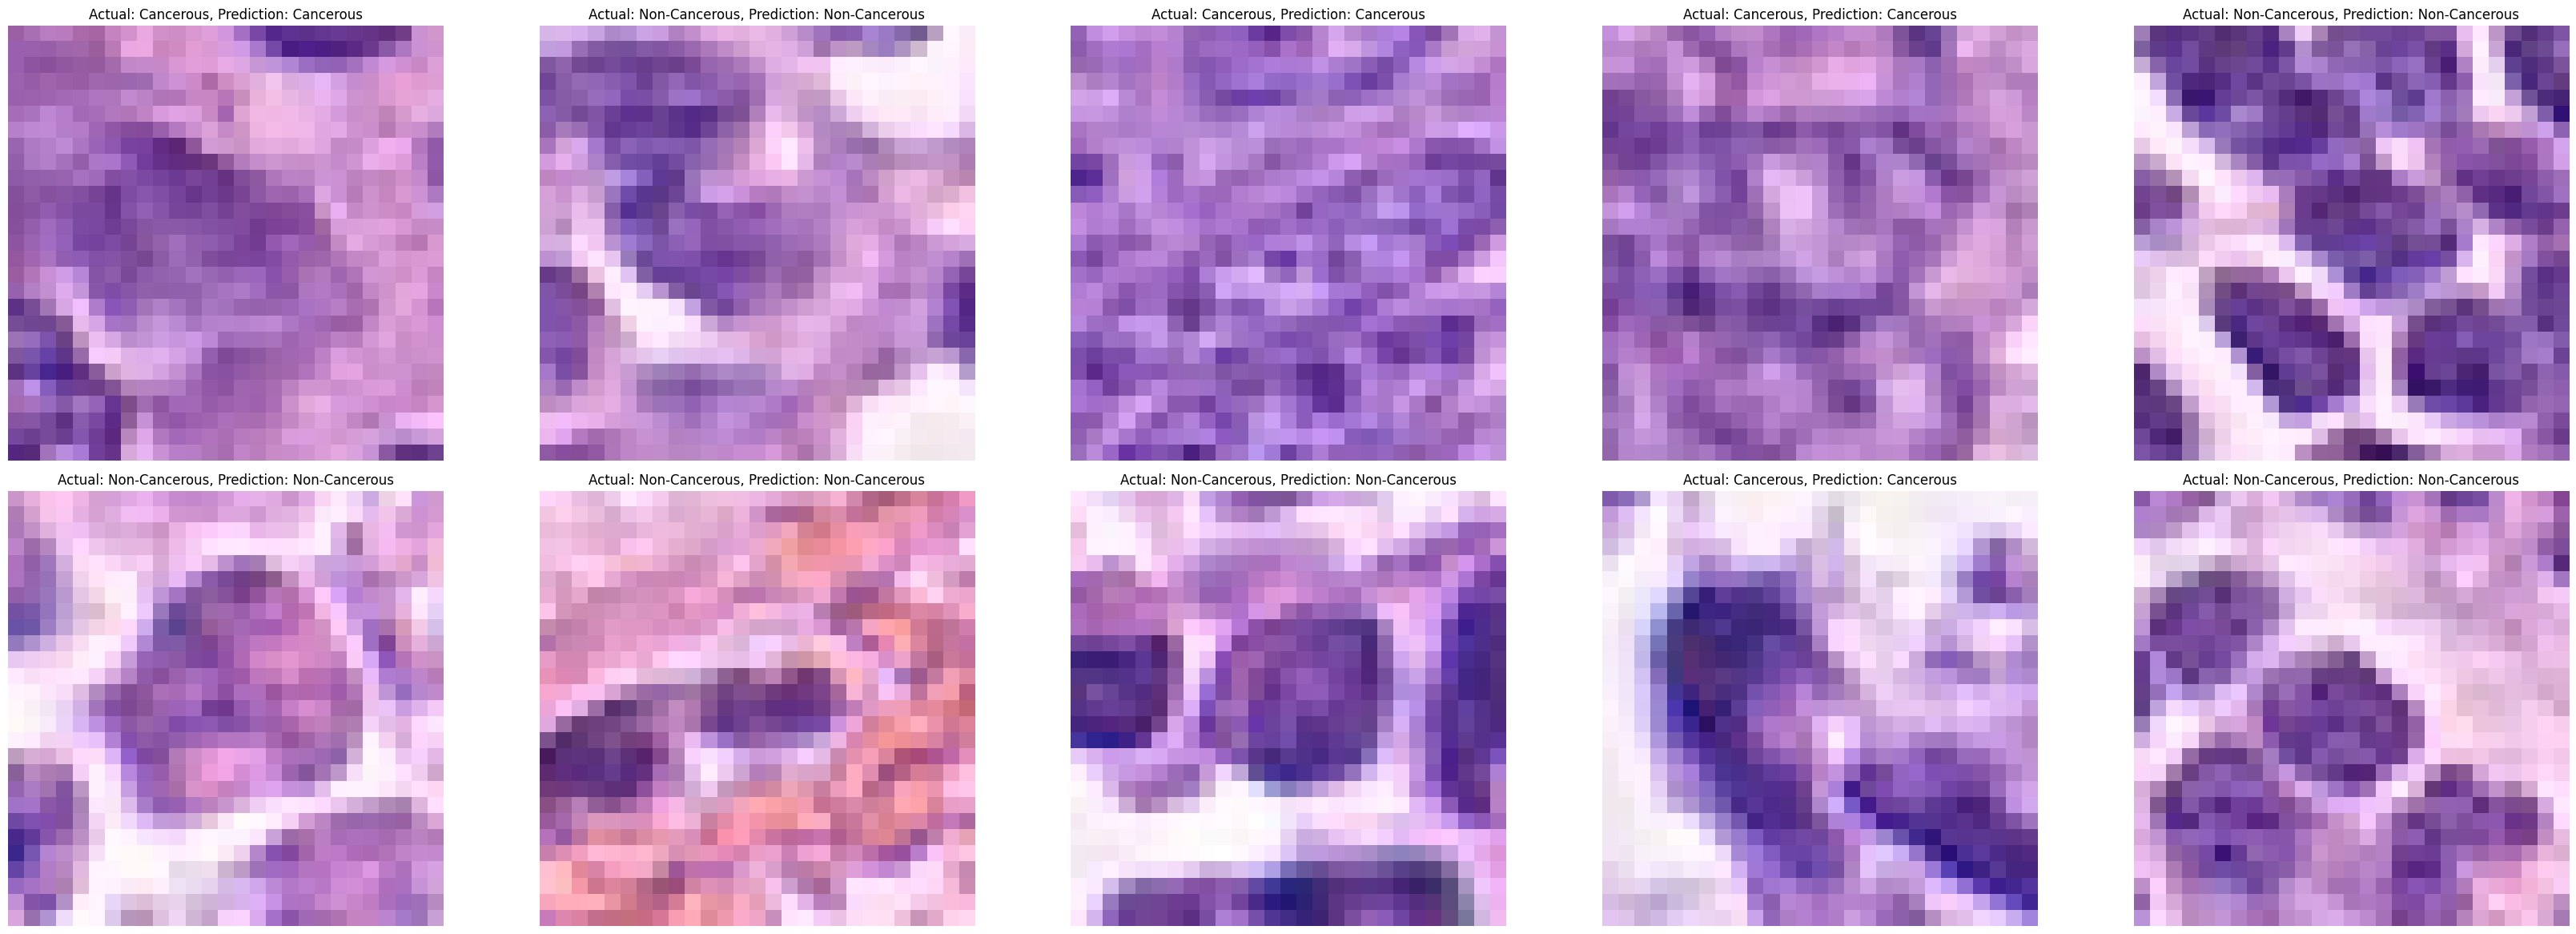

In [38]:
label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(35,12))
batches = 0
num_images_to_display = 10
rows = 2
cols = (num_images_to_display + rows - 1) // rows

for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches <= num_images_to_display:
            row_index = (batches - 1) // cols
            col_index = (batches - 1) % cols + 1
            plt.subplot(rows,cols,batches)
            plt.imshow(x[0])

            actual_class = d_inv[int(y[0])]  # Directly use the binary label
            predicted_probability = y_hat[0][0] # Get the probability of the cell being cancerous
            predicted_class = d_inv[1] if predicted_probability >= 0.5 else d_inv[0]

            plt.title(f"Actual: {actual_class}, Prediction: {predicted_class}")
            
        else:
            break
        plt.tight_layout()
        plt.axis('off')

### Baseline Model to predict 'cellType'

This model will be trained to predict the cell type based on the other features of the dataset. The 'cellType' column we are going to be predicting contains values 0, 1, 2, and 3. Which correspond to the following cell types:
- 0: fibroblast
- 1: inflammatory
- 2: epithelial
- 3: others

In the EDA we observed an imbalance in the class distribution of 'cellType' and we fixed that in the pre-processing stage by calculating class weights for the model.\
While building our models we will use the class weights we calculated to ensure that our models appropriately represent each class especially the underrepresented classes. This will lead to more balanced and reliable predictions.

Misclassifying a cell into the wrong category can lead to incorrect biological insights, which could affect further analysis or experimental procedures. Therefore, when selecting performance metrics, we need to focus on metrics that not only measure overall accuracy but also ensure that we are correctly identifying each class.

To achieve this, we will use the following as our key performance metrics:
- recall
- precision
- categorical accuracy

We will set the layer dimension hyperparameter to 256, we can change this later as we see fit. We will set the model's output classes to 4 so that it matches the output of our 'cellType' variable. 

In [39]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

AUTOTUNE = tf.data.experimental.AUTOTUNE

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [40]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_14 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,156 (2.14 MB)

 Trainable params: 561,156 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

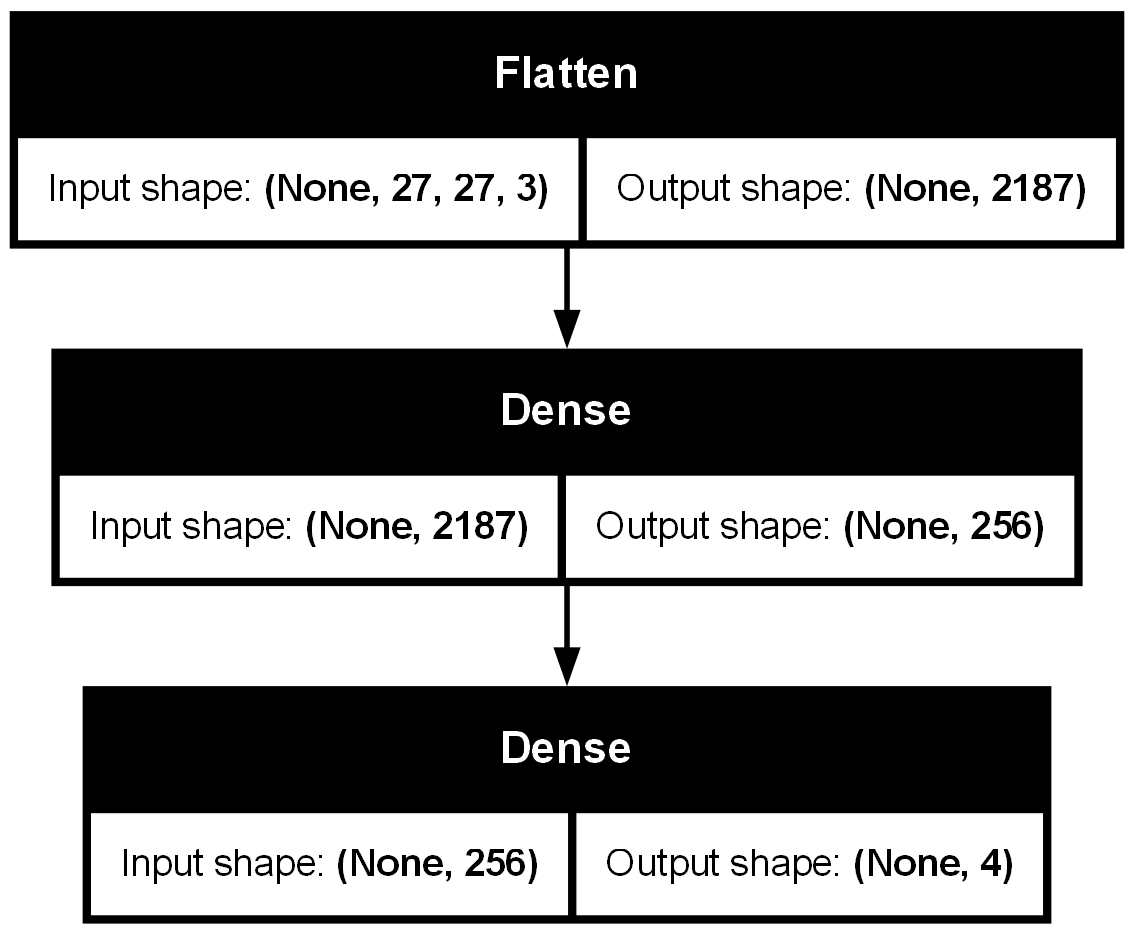

In [41]:
tf.keras.utils.plot_model(model, show_shapes=True)

Lets compile the model.\
We will use categorical cross entropy for the loss function since our target variable 'cellType' is categorical.

In [42]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'categorical_accuracy']
)

Lets train the model and use class weights to balance the classes:

In [43]:
train_data['cellType'] = train_data['cellType'].astype('string')
val_data['cellType'] = val_data['cellType'].astype('string')

train_datagen_ct = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_ct = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen_ct.flow_from_dataframe(
    dataframe=train_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

validation_generator = val_datagen_ct.flow_from_dataframe(
    dataframe=val_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0, class_weight = ct_class_weights_dict)

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


Lets plot the learning curve of the model against the loss, recall, precision, and category accuracy:

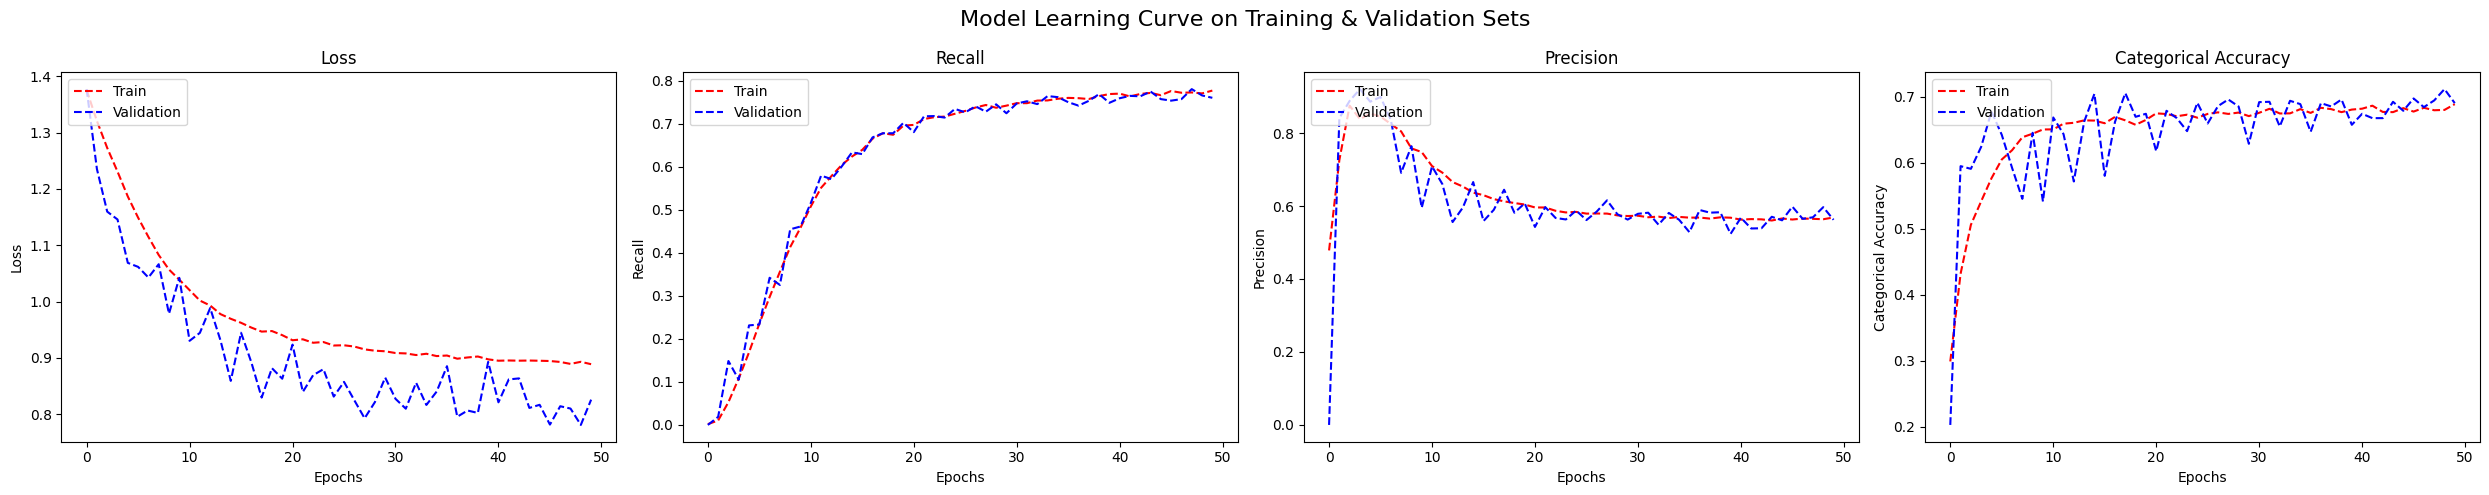

In [48]:
def plot_learning_curve(train_loss, val_loss, 
                        train_metric_1, val_metric_1, 
                        train_metric_2, val_metric_2,
                        train_metric_3, val_metric_3,
                        metric_name_1, metric_name_2, metric_name_3,
                        title):
    
    plt.figure(figsize=(25,5))
    
    # Plot loss
    plt.subplot(1, 4, 1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot metric 1 (Recall)
    plt.subplot(1, 4, 2)
    plt.plot(train_metric_1, 'r--')
    plt.plot(val_metric_1, 'b--')
    plt.xlabel("Epochs")
    plt.ylabel(metric_name_1)
    plt.title(metric_name_1)
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot metric 2 (Precision)
    plt.subplot(1, 4, 3)
    plt.plot(train_metric_2, 'r--')
    plt.plot(val_metric_2, 'b--')
    plt.xlabel("Epochs")
    plt.ylabel(metric_name_2)
    plt.title(metric_name_2)
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot metric 3 (Accuracy)
    plt.subplot(1, 4, 4)
    plt.plot(train_metric_3, 'r--')
    plt.plot(val_metric_3, 'b--')
    plt.xlabel("Epochs")
    plt.ylabel(metric_name_3)
    plt.title(metric_name_3)
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
# print(history.history.keys())
plot_learning_curve(
    history.history['loss'], history.history['val_loss'],
    history.history['recall_14'], history.history['val_recall_14'],
    history.history['precision_14'], history.history['val_precision_14'],
    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
    metric_name_1='Recall', 
    metric_name_2='Precision',
    metric_name_3='Categorical Accuracy',
    title='Model Learning Curve on Training & Validation Sets'
)

Observations:
- there is a noticeable amount of noise in the validation set
- there is a wide gap between training and validation sets in the loss function
- recall and categorical accuracy increase as the model trains
- precision has a shap increase but then gradually decreases

Lets evaluate the model and see how it performs:

In [49]:
test_data['cellType'] = test_data['cellType'].astype('string')
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='./patch_images/',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
model.evaluate(test_generator)

Found 1980 validated image filenames belonging to 4 classes.
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.6732 - loss: 0.8270 - precision_14: 0.5516 - recall_14: 0.7637


[0.8195227384567261,
 0.7626262903213501,
 0.5602968335151672,
 0.6767676472663879]

Lets look at a sample of 10 images of cells and see how our baseline model predicts the cell types:

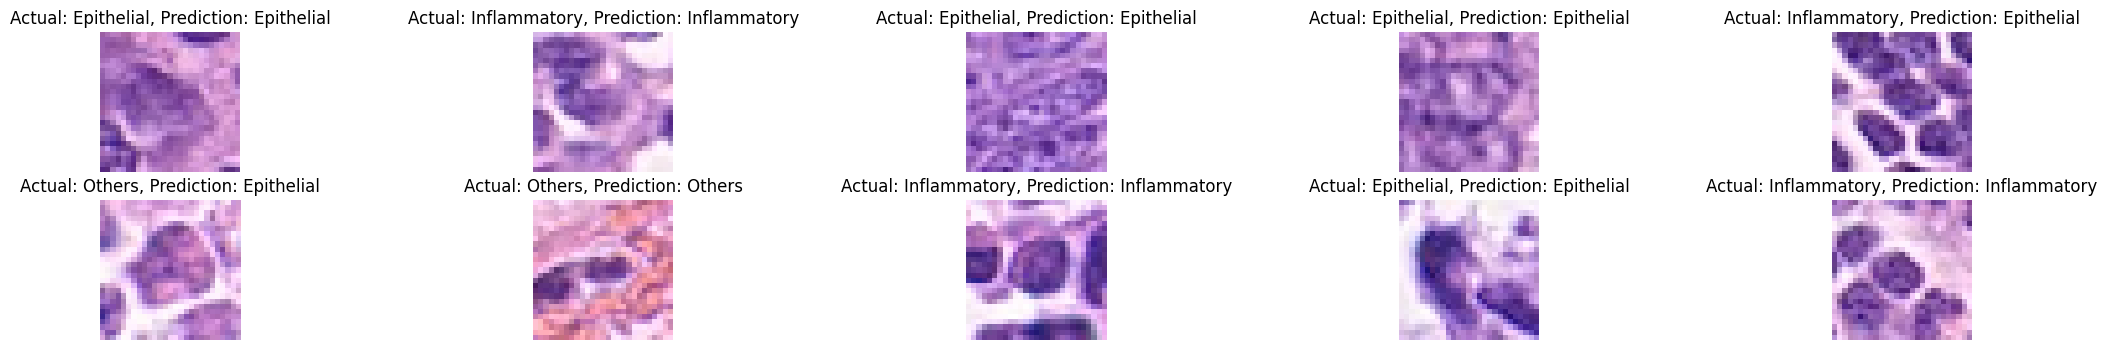

In [50]:
label_names = {'Fibroblast' : 0, 'Inflammatory' : 1, 'Epithelial' : 2, 'Others' : 3}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(27,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 11:
            row_index = (batches - 1) // cols
            col_index = (batches - 1) % cols + 1
            plt.subplot(rows,cols,batches)
            plt.imshow(x[0])
            plt.title("Actual: {}, Prediction: {}".format(d_inv[int(np.argmax(y[0]))], d_inv[int(np.argmax(y_hat[0]))]))            
        else:
            break
        
        plt.axis('off')